# EVS-POT
Use a function to map the (DH0, n_sigma) to 1D and estimate the probability.


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math
import clusterfit as cf
plt.style.use('./nice.mplstyle')

def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    """Deal with my messy naming conventions."""
    if 'scaling_relation' in data.columns:
        df = data[data['scaling_relation'] == relation]
    elif 'Relations' in data.columns:
        df = data[data['Relations'] == relation]
    else:
        raise Exception('Relation/scaling relation column not found or recognised.')
    
    if 'DeltaH0' in df.columns:
        delta_h0 = df['DeltaH0'].values
    elif '$\Delta H_0\,(\%)$' in df.columns:
        delta_h0 = df['$\Delta H_0\,(\%)$'].values
    elif 'Delta_H0' in df.columns:
        delta_h0 = df['Delta_H0'].values 
    else:
        raise Exception('The delta H0 column not found or recognised.')
    
    
    if 'Significance $(\sigma)$' in df.columns:
        significance = df['Significance $(\sigma)$'].values
    elif 'Significance' in df.columns:
        significance = df['Significance'].values
    else:
        raise Exception('The significance column not found or recognised.')
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    """Calculate the p-value by number of sigma deviation from the mean."""
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_evt_p_value(delta_h0_proj, target_value, percentile=90):
    # Determine the threshold
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold  # Tail data

    # Fit GPD to the tail data
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # Tail survival probability (proportion of data in the tail)
    tail_prob = np.sum(delta_h0_proj >= threshold) / len(delta_h0_proj)

    if target_value > threshold:
        # Conditional probability adjusted to match at the threshold
        p_value_evt = (1 - genpareto.cdf(target_value - threshold, *params)) * tail_prob
    else:
        # Empirical CDF for the bulk region
        p_value_evt = np.sum(delta_h0_proj >= target_value) / len(delta_h0_proj)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_evt)

    return p_value_evt, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

## Read and plot
The MCMC run, for Lx-T and Ysz-T, output data and plot.

Prob of obtaining (ΔH%, nσ) = [8.7 2.4] in LX-T.
Sigma deviation: 1.76σ, p-value: 0.0782
Probability of target value: 0.085\,(1.72\sigma)
Frequentist:148/1727 p=0.08569774174869717 (1.7185423224494147)


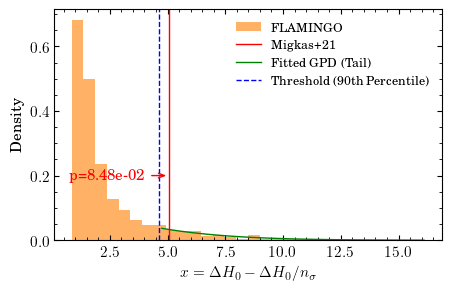

Prob of obtaining (ΔH%, nσ) = [14.   2.6] in YSZ-T.
Sigma deviation: 5.59σ, p-value: 2.27e-08
Probability of target value: 0.0049\,(2.82\sigma)
Frequentist:10/1727 p=0.005790387955993051 (2.75942103271546)


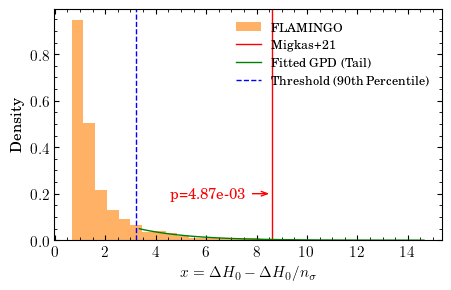

In [3]:
file_path_mc = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_mc_scatter.csv'
data_type_mc = 'mc'
data_mc = load_data(file_path_mc, data_type_mc)

target_point_arr_mc = [np.array([8.7, 2.4]), np.array([14, 2.6])]
for relation, target_point in zip(['LX-T', 'YSZ-T'], target_point_arr_mc):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_mc, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    percentile = 90
    p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, percentile)
    print(f"Probability of target value: {p_value_evt:.2g}\\,({sigma_evt:.3g}\\sigma)")
    
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # One can get the frequency when the sigma value is low
    p_value_freq = np.sum(delta_h0_proj > target_value)/len(delta_h0_proj)
    n_sigma_freq = cf.n_sigma1d(p_value_freq)
    print(f'Frequentist:{np.sum(delta_h0_proj > target_value)}/{len(delta_h0_proj)} p={p_value_freq} ({n_sigma_freq})')
    
    # Plotting results
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='#ff7f00', label='FLAMINGO')
    x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.axvline(target_value, color='red', linestyle='-', label=f'Migkas+21')
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
    
    # Annotate the plot
    plt.annotate(f'p={p_value_evt:.2e}', 
         xy=(target_value, 0.2), xycoords='data',
         xytext=(target_value - 1, 0.2), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

    plt.xlabel('$x=\\Delta H_0 - \\Delta H_0 / n_\\sigma$')
    plt.ylabel('Density')
    plt.legend(fontsize=9)

#     plt.savefig(f'./to_paper/evs_mcmc_{relation[1]}_scatter.pdf', bbox_inches='tight')   # save the figure
    plt.show()

The M21 fits, of Lx-T and Ysz-T separately. Data and plot below.

Prob of obtaining (ΔH%, nσ) = [8.7 2.6] in $L_\mathrm{{X}}-T$.
Sigma deviation: 0.742σ, p-value: 0.458
Probability of target value: 0.23\,(1.2\sigma)
Frequentist:399/1725 p=0.23130434782608697 (1.1970056621209255)


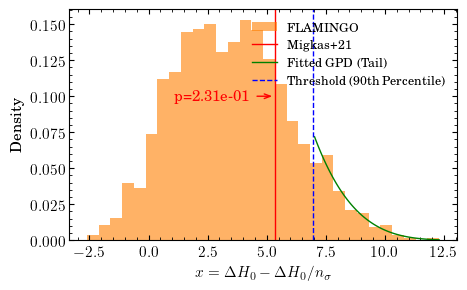

Prob of obtaining (ΔH%, nσ) = [14.   4.1] in $Y_\mathrm{{SZ}}-T$.
Sigma deviation: 3.01σ, p-value: 0.00262
Probability of target value: 0.0013\,(3.22\sigma)
Frequentist:4/1724 p=0.002320185614849188 (3.045856473137568)


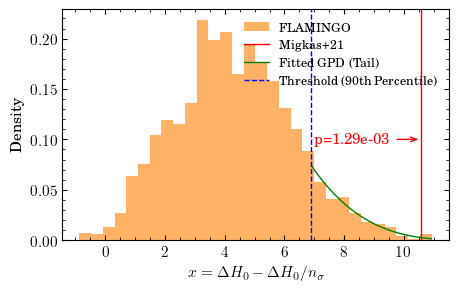

In [5]:
file_path_direct_compare = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare_scatter.csv'
data_type_direct_compare = 'direct_compare'
data_direct_compare = load_data(file_path_direct_compare, data_type_direct_compare)

target_point_arr_direct_compare = [np.array([8.7, 2.6]), np.array([14, 4.1])]
for relation, target_point in zip(['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$'], target_point_arr_direct_compare):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_direct_compare, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    percentile = 90         # Set the threshold
    p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, percentile)
    print(f"Probability of target value: {p_value_evt:.2g}\\,({sigma_evt:.3g}\\sigma)")

    # One can get the frequency when the sigma value is low
    p_value_freq = np.sum(delta_h0_proj > target_value)/len(delta_h0_proj)
    n_sigma_freq = cf.n_sigma1d(p_value_freq)
    print(f'Frequentist:{np.sum(delta_h0_proj > target_value)}/{len(delta_h0_proj)} p={p_value_freq} ({n_sigma_freq})')
    
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params
    
    # Plotting results
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='#ff7f00', label='FLAMINGO')
    x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.axvline(target_value, color='red', linestyle='-', label=f'Migkas+21')
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
    
    # Annotate the plot
    plt.annotate(f'p={p_value_evt:.2e}', 
         xy=(target_value, 0.1), xycoords='data',
         xytext=(target_value - 1, 0.1), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

    plt.xlabel('$x=\\Delta H_0 - \\Delta H_0 / n_\\sigma$')
    plt.ylabel('Density')
    plt.legend(fontsize=9)

#     plt.savefig(f'./to_paper/evs_m21_{relation[1]}_scatter.pdf', bbox_inches='tight')  # save the figure
    plt.show()

Now the MCMC joint result.

In [11]:
file_path_joint = '../data/analysis_all/h0_mc_joint_scatter_all.csv'
data_joint = load_data(file_path_joint, 'joint')
print(len(data_joint))

1726


1726
Prob of obtaining (ΔH%, nσ) = [9.  5.9] in joint result.
Sigma deviation: 3.23σ, p-value: 0.00124
Probability of target value: 0.0205, (2.32sigma)
Frequentist:32/1726 p=0.01853997682502897 (2.3546536560864446)


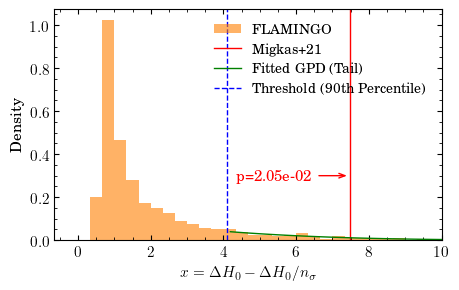

In [12]:
# ** This plot is put in the paper **
file_path_joint = '../data/analysis_all/h0_mc_joint_scatter_all.csv'
data_joint = load_data(file_path_joint, 'joint')
print(len(data_joint))
target_point_joint = np.array([9.0, 5.9])

print(f'Prob of obtaining (ΔH%, nσ) = {target_point_joint} in joint result.')
delta_h0_joint = data_joint['DeltaH0'].values
significance_joint = data_joint['Significance'].values
delta_h0_proj_joint = default_proj(delta_h0_joint, significance_joint)
target_value_joint = default_proj(target_point_joint[0], target_point_joint[1])

sigma_deviation_joint, p_value_sigma_joint = calculate_sigma_p_value(delta_h0_proj_joint, target_value_joint)
print(f"Sigma deviation: {sigma_deviation_joint:.3g}σ, p-value: {p_value_sigma_joint:.3g}")

percentile_joint = 90
p_value_evt_joint, sigma_evt_joint = calculate_evt_p_value(delta_h0_proj_joint, target_value_joint, percentile_joint)
print(f"Probability of target value: {p_value_evt_joint:.3g}, ({sigma_evt_joint:.3g}sigma)")

# One can get the frequency when the sigma value is low
p_value_freq = np.sum(delta_h0_proj_joint > target_value_joint)/len(delta_h0_proj_joint)
n_sigma_freq = cf.n_sigma1d(p_value_freq)
print(f'Frequentist:{np.sum(delta_h0_proj_joint > target_value_joint)}/{len(delta_h0_proj_joint)} p={p_value_freq} ({n_sigma_freq})')
    
threshold_joint = np.percentile(delta_h0_proj_joint, percentile_joint)
exceedances_joint = delta_h0_proj_joint[delta_h0_proj_joint > threshold_joint] - threshold_joint
params_joint = genpareto.fit(exceedances_joint)
shape_joint, loc_joint, scale_joint = params_joint


# Plotting results for joint result
plt.figure(figsize=(5, 3))
x_vals_joint = np.linspace(threshold_joint, delta_h0_proj_joint.max(), 100)
gpd_pdf_joint = genpareto.pdf(x_vals_joint - threshold_joint, shape_joint, loc_joint, scale_joint) * (1 - percentile_joint / 100)
plt.hist(delta_h0_proj_joint, bins=30, range=(0, 10), density=True, alpha=0.6, color='#ff7f00', label='FLAMINGO')
plt.axvline(target_value_joint, color='red', linestyle='-', label=f'Migkas+21')
plt.plot(x_vals_joint[1:], gpd_pdf_joint[1:], color='g', label='Fitted GPD (Tail)')
plt.axvline(threshold_joint, color='blue', linestyle='--', label=f'Threshold ({percentile_joint}th Percentile)')

# Annotate the plot
plt.annotate(f'p={p_value_evt_joint:.2e}', 
         xy=(target_value_joint, 0.3), xycoords='data',
         xytext=(target_value_joint - 1, 0.3), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

plt.xlabel('$x=\\Delta H_0 - \\Delta H_0 / n_\\sigma$')
plt.ylabel('Density')
plt.xlim(right=10)
plt.legend(fontsize=10)

# plt.savefig('./to_paper/evs_joint_scatter.pdf', bbox_inches='tight')
plt.show()